In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

In [5]:
## Read the train and test dataset and check the top few lines ##
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print("Number of rows & columns in train dataset : ",train_df.shape)
print("Number of rows $ columns in test dataset : ",test_df.shape)

Number of rows & columns in train dataset :  (19579, 3)
Number of rows $ columns in test dataset :  (8392, 2)


In [6]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [7]:
## check class imbalance
counts = train_df['author'].value_counts()
print(counts)

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64


In [9]:
grouped_df = train_df.groupby('author')
print(grouped_df.head())
for name, group in grouped_df:
    print("\nAuthor name : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["text"])
        cnt += 1
        if cnt == 5:
            break
    print("\n")

         id                                               text author
0   id26305  This process, however, afforded me no means of...    EAP
1   id17569  It never once occurred to me that the fumbling...    HPL
2   id11008  In his left hand was a gold snuff box, from wh...    EAP
3   id27763  How lovely is spring As we looked from Windsor...    MWS
4   id12958  Finding nothing else, not even gold, the Super...    HPL
5   id22965  A youth passed in solitude, my best years spen...    MWS
6   id09674  The astronomer, perhaps, at this point, took r...    EAP
7   id13515        The surcingle hung in ribands from my body.    EAP
8   id19322  I knew that you could not say to yourself 'ste...    EAP
9   id00912  I confess that neither the structure of langua...    MWS
10  id16737  He shall find that I can feel my injuries; he ...    MWS
12  id19764  Herbert West needed fresh bodies because his l...    HPL
13  id18886  The farm like grounds extended back very deepl...    HPL
15  id12799  He had 

In [10]:
## Number of words in the text ##
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["unique_words"] = train_df["text"].apply(lambda x: len(pd.unique(str(x).split())))
test_df["unique_words"] = test_df["text"].apply(lambda x: len(pd.unique(str(x).split())))

## Number of stop words in the text ##
train_df["stop_words"] = train_df["text"].apply(lambda x: len([i for i in str(x).lower().split() if i in eng_stopwords]))
test_df["stop_words"] = test_df["text"].apply(lambda x: len([i for i in str(x).lower().split() if i in eng_stopwords]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

train_df["num_words"] = train_df["text"].apply(lambda x: np.mean([len(i) for i in str(x).split()]))
test_df["num_words"] = test_df["text"].apply(lambda x: np.mean([len(i) for i in str(x).split()]))

# summary statistics of the meta features
print("\nSummary of Training Set Numeric Variables\n")
print(train_df.groupby("author").mean())
print("\nSummary of Testing Set Numeric Variables\n",train_df.groupby("author").mean())


Summary of Training Set Numeric Variables

        num_words  unique_words  stop_words  num_punctuations  \
author                                                          
EAP      4.644952     21.894937   12.626456          4.096329   
HPL      4.625193     24.437977   12.970186          3.206921   
MWS      4.598182     23.544672   13.742224          3.833719   

        num_words_upper  num_words_title  
author                                    
EAP            0.553291         2.102405  
HPL            0.500266         2.334694  
MWS            0.751489         2.124255  

Summary of Testing Set Numeric Variables
         num_words  unique_words  stop_words  num_punctuations  \
author                                                          
EAP      4.644952     21.894937   12.626456          4.096329   
HPL      4.625193     24.437977   12.970186          3.206921   
MWS      4.598182     23.544672   13.742224          3.833719   

        num_words_upper  num_words_title  
aut

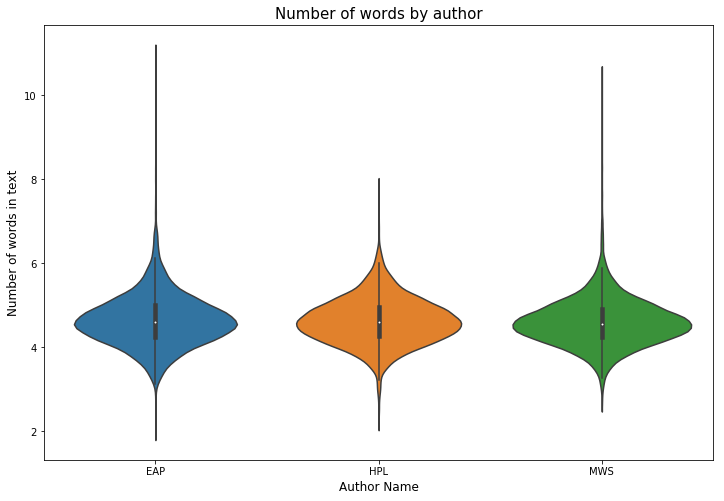

In [11]:
train_df['num_words'].loc[train_df['num_words']>80] = 80 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn import cross_validation, metrics

encoder = LabelEncoder()
encoder.fit(train_df['author'])
train_y = encoder.transform(train_df['author'])

train_tfidf = train_df['text'].values.tolist()
test_tfidf = test_df['text'].values.tolist()

#Naive Bayes on word count Tfidf Vectorizer
NBclassifier = Pipeline([('vect', CountVectorizer(analyzer='word')),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
])
NBclassifier.fit(train_tfidf, train_y)

#Predict training set:
dtrain_predictions = NBclassifier.predict_proba(train_tfidf)
dtrain_pred_class = NBclassifier.predict(train_tfidf)

#Predict testing set:
y_pred_proba = NBclassifier.predict_proba(test_tfidf)

#Perform cross-validation:
cv_score = cross_validation.cross_val_score(NBclassifier, train_tfidf, train_y, cv=5,scoring='accuracy')  
print("Train Data Accuracy(Word): Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
print("Confusion matrix after prediction\n", metrics.confusion_matrix(train_y, dtrain_pred_class))

#id,EAP,HPL,MWS
#id07943,0.33,0.33,0.33
x = y_pred_proba[:,0]

my_submission = pd.DataFrame({'id': test_df['id'], 'EAP': y_pred_proba[:,0], 
                              'HPL': y_pred_proba[:,1], 'MWS': y_pred_proba[:,2] })
my_submission.to_csv('submission.csv', index=False)

C:\Users\prita\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Train Data Accuracy(Word): Mean - 0.810971 | Std - 0.00221224 | Min - 0.8069459 | Max - 0.8135853
Confusion matrix after prediction
 [[7602   57  241]
 [ 816 4621  198]
 [ 588   55 5401]]


In [13]:
#Naive Bayes on Char count Tfidf Vectorizer
NBclassifier2 = Pipeline([('vect', CountVectorizer(analyzer='char')),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
])
NBclassifier2.fit(train_tfidf, train_y)
#self.vect = TfidfVectorizer(sublinear_tf=True, max_df=0.5, analyzer='word', stop_words='english')

#Predict training set:
dtrain_predictions_2 = NBclassifier2.predict_proba(train_tfidf)
dtrain_pred_class2 = NBclassifier.predict(train_tfidf)

#Predict testing set:
y_pred_proba_2 = NBclassifier2.predict_proba(test_tfidf)

#Perform cross-validation:
cv_score = cross_validation.cross_val_score(NBclassifier2, train_tfidf, train_y, cv=5, scoring='accuracy')  
print("Train Data Accuracy(Char): Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
print("Confusion matrix after prediction\n", metrics.confusion_matrix(train_y, dtrain_pred_class2))

Train Data Accuracy(Char): Mean - 0.4044641 | Std - 0.001026444 | Min - 0.4034729 | Max - 0.4063857
Confusion matrix after prediction
 [[7602   57  241]
 [ 816 4621  198]
 [ 588   55 5401]]


In [23]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

#author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
#train_y = train_df['author'].map(author_mapping_dict)

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

xgb2 = XGBRegressor(learning_rate =0.9, n_estimators=15, max_depth=8, min_child_weight=12, gamma=0,
        subsample=0.8, colsample_bytree=0.8, objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27)
    
xgb_param = xgb2.get_xgb_params()
extra = {'num_class': 3}
xgb_param.update(extra)
    
xgtrain = xgb.DMatrix(train_X.values, label=train_y.values)
xgtest = xgb.DMatrix(test_X)

#cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=15, nfold=5, metrics='logloss', early_stopping_rounds=50)

#print("Cross validation results\n",cvresult)
#xgb2.set_params(n_estimators=cvresult.shape[0])
    
#Fit the algorithm on the data
xgb2.fit(train_X, train_y, eval_metric='logloss')
        
#Predict training set:
dtrain_predictions = xgb2.predict(xgtrain)
    
#Print model report:
print("\nModel Report")
print("LogLoss : %.4g" % np.sqrt(metrics.mean_squared_error(train_y, dtrain_predictions)))
    
#Predict on testing data:
test_X['author'] = xgb2.predict(xgtest)

#Export submission file:
submission = pd.DataFrame(test_X)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_df['id'])
submission.to_csv(filename, index=False)

XGBoostError: b'value 0 for Parameter num_class should be greater equal to 1'